In [22]:
import os
import json
import scipy.io
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import shutil

# Paths
input_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_origin_gentuity"
output_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"

# Ensure output folders exist
train_dir = Path(output_dir) / "train"
test_dir = Path(output_dir) / "test"
train_images_dir = train_dir / "images"
train_masks_dir = train_dir / "annotations"
test_images_dir = test_dir / "images"
test_masks_dir = test_dir / "annotations"
train_images_dir.mkdir(parents=True, exist_ok=True)
train_masks_dir.mkdir(parents=True, exist_ok=True)
test_images_dir.mkdir(parents=True, exist_ok=True)
test_masks_dir.mkdir(parents=True, exist_ok=True)

# Function to convert binary mask to JSON (includes patient ID)
def mask_to_json(binary_mask, unique_id, case_name):
    indices = np.argwhere(binary_mask > 0)
    json_data = {
        "case_name": case_name,
        "unique_id": unique_id,    # Include the patient ID
        "mask": indices.tolist()  # Convert array to list for JSON
    }
    return json_data

# Assign unique patient IDs
patients = sorted(Path(input_dir).iterdir())
patient_mapping = {patient.name: idx for idx, patient in enumerate(patients)}

# Assuming patients is a list of directories for each patient
for patient_folder in patients:
    unique_id = patient_mapping[patient_folder.name]
    images_path = patient_folder / "images"
    masks_path = patient_folder / "annotations"
    
    # Get list of image files
    image_files = sorted(images_path.glob("*.tiff"))
    
    # Load the .mat file containing all the masks for this patient
    mask_file = sorted(masks_path.glob("*.mat"))[0]
    mat_data = scipy.io.loadmat(mask_file)
    
    # Assuming that the mat file contains a variable that is a list of binary masks (adjust if needed)
    binary_masks = mat_data["labels"]  # Adjust according to the actual structure of your .mat file

    # Ensure binary_masks has the correct shape (number of masks, height, width)
    if binary_masks.shape[0] != len(image_files):
        binary_masks = np.transpose(binary_masks, (2, 0, 1))
    
    # Ensure we have the same number of masks as images
    assert len(binary_masks) == len(image_files), "Number of masks does not match number of images"

    # Split data: 90% train, 10% test (without shuffling)
    train_images, test_images, train_masks, test_masks = train_test_split(
        image_files, binary_masks, test_size=0.1, shuffle=False
    )

    # Save train data
    for image, mask in zip(train_images, train_masks):
        image_dest = train_images_dir / f"uniqueid_{unique_id}_{image.name}"
        shutil.copy(image, image_dest)
        
        # Convert the mask to JSON with the patient ID
        json_mask = mask_to_json(mask, unique_id, patient_folder.name)
        mask_dest = train_masks_dir / f"uniqueid_{unique_id}_{image.stem}.json"
        mask_dest.write_text(json.dumps(json_mask))
    
    # Save test data
    for image, mask in zip(test_images, test_masks):
        image_dest = test_images_dir / f"uniqueid_{unique_id}_{image.name}"
        shutil.copy(image, image_dest)
        
        # Convert the mask to JSON with the patient ID
        json_mask = mask_to_json(mask, unique_id, patient_folder.name)
        mask_dest = test_masks_dir / f"uniqueid_{unique_id}_{image.stem}.json"
        mask_dest.write_text(json.dumps(json_mask))

print("Data successfully split and saved!")

Data successfully split and saved!


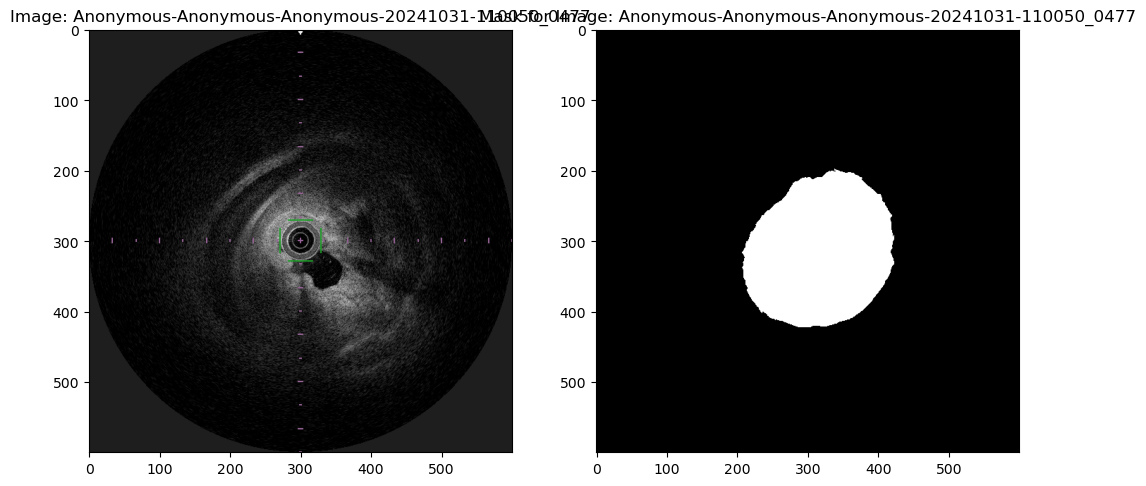

Unique ID: 1


In [94]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo\train\images\uniqueid_1_run2_slice_613.tiff"
mask_path = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo\train\annotations\uniqueid_1_run2_slice_613.json"

image_example = Image.open(image_path).convert("RGB")

with open(mask_path, 'r') as f:
    mask_data = json.load(f)

# Extract the mask coordinates and create a binary mask
mask_example = np.zeros((image_example.height, image_example.width), dtype=np.uint8)
for coord in mask_data['mask']:
    mask_example[coord[0], coord[1]] = 1

# Extract the unique ID
unique_id = mask_data['unique_id']

# Plot the image and mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the image
ax[0].imshow(image_example)
ax[0].set_title(f"Image: {image.stem}")

# Plot the mask
ax[1].imshow(mask_example, cmap='gray')
ax[1].set_title(f"Mask for Image: {image.stem}")

plt.show()

# Print the unique ID
print(f"Unique ID: {unique_id}")

In [26]:
import os
import json
import scipy.io
from pathlib import Path
import numpy as np
import pydicom
from PIL import Image
import shutil

# Paths
input_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_origin_terumo"
output_dir = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_terumo"

# Ensure output folders exist
train_dir = Path(output_dir) / "train"
train_images_dir = train_dir / "images"
train_masks_dir = train_dir / "annotations"
train_images_dir.mkdir(parents=True, exist_ok=True)
train_masks_dir.mkdir(parents=True, exist_ok=True)

# Function to convert binary mask to JSON (includes patient ID)
def mask_to_json(binary_mask, unique_id, case_name):
    indices = np.argwhere(binary_mask > 0)
    json_data = {
        "case_name": case_name,
        "unique_id": unique_id,    # Include the patient ID
        "mask": indices.tolist()  # Convert array to list for JSON
    }
    return json_data

# Assign unique patient IDs
patients = sorted(Path(input_dir).iterdir())
patient_mapping = {patient.name: idx for idx, patient in enumerate(patients)}

# Assuming patients is a list of directories for each patient
for patient_folder in patients:
    unique_id = patient_mapping[patient_folder.name]
    images_path = patient_folder / "images"
    masks_path = patient_folder / "annotations"
    
    # Get the DICOM file
    dicom_file = sorted(images_path.glob("*.dcm"))[0]
    
    # Load the DICOM file and check if it contains slices
    dicom_data = pydicom.dcmread(dicom_file)
    dicom_image = dicom_data.pixel_array
    
    # Check if dicom_image is 4D (1023 slices, 600x600 size, 3 channels)
    if dicom_image.ndim == 4:
        # Load the .mat file containing the binary masks for this patient
        mask_file = sorted(masks_path.glob("*.mat"))[0]
        mat_data = scipy.io.loadmat(mask_file)
        
        # Assuming that the mat file contains a variable that is a list of binary masks (adjust if needed)
        binary_masks = mat_data["labels"]  # Adjust according to the actual structure of your .mat file
        
        # Ensure binary_masks has the correct shape (number of masks, height, width)
        if binary_masks.shape[0] != dicom_image.shape[0]:  # Ensure number of masks matches the number of slices
            binary_masks = np.transpose(binary_masks, (2, 0, 1))
        
        # Iterate over each slice and save it as a separate .tiff file with its corresponding mask as .json
        for i in range(dicom_image.shape[0]):
            slice_image = dicom_image[i]  # Get the i-th slice
            slice_image_rgb = np.array(slice_image, dtype=np.uint8)  # Ensure it's the correct dtype
            
            # Convert the slice to an Image object and save it as .tiff
            image_dest = train_images_dir / f"uniqueid_{unique_id}_{dicom_file.stem}_slice_{i+1}.tiff"
            Image.fromarray(slice_image_rgb).save(image_dest)
            
            # Get the corresponding binary mask for the current slice
            mask = binary_masks[i]  # This corresponds to the i-th mask slice
            
            # Convert the mask to JSON with the patient ID
            json_mask = mask_to_json(mask, unique_id, patient_folder.name)
            mask_dest = train_masks_dir / f"uniqueid_{unique_id}_{dicom_file.stem}_slice_{i+1}.json"
            mask_dest.write_text(json.dumps(json_mask))
    else:
        print(f"Unexpected DICOM image shape for {dicom_file.stem}, expected 4D array.")
        
print("Data successfully prepared!")

Data successfully prepared!


In [68]:
from pathlib import Path
import json
import pandas as pd
from tqdm import tqdm

def precompute_metadata(root_dir):
    """
    Precompute metadata for the OCT dataset and return it as a DataFrame with progress tracking.
    
    Args:
        root_dir (str): Root directory containing the dataset.
        
    Returns:
        pd.DataFrame: DataFrame containing precomputed metadata.
    """
    root_dir = Path(root_dir)
    images_dir = root_dir / "train" / "images"
    masks_dir = root_dir / "train" / "annotations"
    
    metadata = []
    image_paths = sorted(images_dir.glob("*.tiff"))
    
    for img_path in tqdm(image_paths, desc="Precomputing metadata", unit="file"):
        mask_path = masks_dir / f"{img_path.stem}.json"
        if not mask_path.exists():
            continue  # Skip if mask file is missing
        
        with open(mask_path, "r") as f:
            mask_data = json.load(f)
            metadata.append({
                "relative_image_path": str(img_path.relative_to(root_dir)),
                "relative_mask_path": str(mask_path.relative_to(root_dir)),
                "unique_id": mask_data["unique_id"]
            })
    
    return pd.DataFrame(metadata)

# Precompute metadata and save it
root_dir = "D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\data_gentuity"
metadata_df = precompute_metadata(root_dir)
metadata_df.to_csv("metadata.csv", index=False)

Precomputing metadata: 100%|██████████| 1576/1576 [03:29<00:00,  7.51file/s]
